# 0. baseline re-preduce

1. 延后第一次（越靠近后面的延缓带来的效果增益越小）的down sample确实会很有效，对于resnet18的效果甚至超过模型宽度(通道数)翻倍的效果; 同时使用实验证明这个性能提升是延缓down sample带来的，而不是卷积核的padding或kernel_size带来的。
2. 一组合适的参数保证网络的充分训练和收敛（num_epoch, lr_period, lr_decay), 同时发现过大的weight_decay也会影响（降低）网络的收敛速度和结果
```
num_epochs = 200
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [80, 150]
lr_decay=0.1
```

# 1. import needed package

In [1]:
from mxnet import autograd
from mxnet import gluon
from mxnet import image
from mxnet import init
from mxnet import nd
from mxnet.gluon.model_zoo import vision as model
from mxnet.gluon import nn
from mxnet.gluon.data import vision
import numpy as np
import random
import mxnet as mx
import sys
sys.path.insert(0, '../../utils')
from netlib import *
import os
import shutil

ctx = mx.gpu(0)

def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))

# 2. data loader, data argument

In [2]:
"""
data loader
"""
def _transform_test(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1))
    return im, nd.array([label]).astype('float32')


def data_loader(batch_size, transform_train, transform_test=None, num_workers=0):
    if transform_train is None:
        transform_train = _transform_train
    if transform_test is None:
        transform_test = _transform_test
        
    # flag=1 mean 3 channel image
    train_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=True, transform=transform_train)
    test_ds = gluon.data.vision.datasets.CIFAR10(root='~/.mxnet/datasets/cifar10', train=False, transform=transform_test)

    loader = gluon.data.DataLoader
    train_data = loader(train_ds, batch_size, shuffle=True, last_batch='keep', num_workers=num_workers)
    test_data = loader(test_ds, batch_size, shuffle=False, last_batch='keep', num_workers=num_workers)
    return train_data, test_data

In [3]:
"""
data argument
"""
def transform_train_DA1(data, label):
    im = data.asnumpy()
    im = np.pad(im, ((4, 4), (4, 4), (0, 0)), mode='constant', constant_values=0)
    im = nd.array(im, dtype='float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, rand_mirror=True,
                                    rand_crop=True,
                                   mean=np.array([0.4914, 0.4822, 0.4465]),
                                   std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2, 0, 1)) # channel x width x height
    return im, nd.array([label]).astype('float32')


def transform_train_DA2(data, label):
    im = data.astype(np.float32) / 255
    auglist = [image.RandomSizedCropAug(size=(32, 32), min_area=0.49, ratio=(0.5, 2))]
    _aug = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, 
                                rand_crop=False, rand_resize=False, rand_mirror=True,
                                mean=np.array([0.4914, 0.4822, 0.4465]),
                                std=np.array([0.2023, 0.1994, 0.2010]),
                                brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3,
                                pca_noise=0.01, rand_gray=0, inter_method=2)
    auglist.append(image.RandomOrderAug(_aug))
    
    for aug in auglist:
        im = aug(im)
    
    im = nd.transpose(im, (2, 0, 1))
    return (im, nd.array([label]).asscalar().astype('float32'))
    

random_clip_rate = 0.3
def transform_train_DA3(data, label):
    im = data.astype(np.float32) / 255
    auglist = [image.RandomSizedCropAug(size=(32, 32), min_area=0.49, ratio=(0.5, 2))]
    _aug = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0, 
                                rand_crop=False, rand_resize=False, rand_mirror=True,
#                                mean=np.array([0.4914, 0.4822, 0.4465]),
#                                std=np.array([0.2023, 0.1994, 0.2010]),
                                brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3,
                                pca_noise=0.01, rand_gray=0, inter_method=2)
    auglist.append(image.RandomOrderAug(_aug))

    for aug in auglist:
        im = aug(im)
        
    if random.random() > random_clip_rate:
        im = im.clip(0, 1)
    _aug = image.ColorNormalizeAug(mean=np.array([0.4914, 0.4822, 0.4465]),
                   std=np.array([0.2023, 0.1994, 0.2010]),)
    im = _aug(im)
    
    im = nd.transpose(im, (2, 0, 1))
    return (im, nd.array([label]).asscalar().astype('float32'))

# 3 data aurgument: mixup
1. mixup define
2. mixup visualize

## 3.1 mixup: define

In [4]:
import numpy as np
def mixup(x1, y1, x2, y2, alpha, num_class):
    y1 = nd.one_hot(y1, num_class)
    y2 = nd.one_hot(y2, num_class)
    
    lam = np.random.beta(alpha, alpha)
    x = lam * x1 + (1 - lam) * x2
    y = lam * y1 + (1 - lam) * y2
    return x, y

## 3.2 mixup: visulize

In [5]:
from mxnet import gluon
from mxnet.gluon.model_zoo import vision as model
from time import time
batch_size = 32
transform_train = _transform_test#transform_train_DA1
train_data, test_data = data_loader(batch_size, transform_train)
mixup_alpha = 1

# for x1, y1 in train_data:
#     for x2, y2 in mixup_train_data:
#         data, label = mixup(x1, y1, x2, y2, mixup_alpha, 10)
#         break
#     break

for x, y in train_data:
    l = x.shape[0] / 2
    data, label = mixup(x[:l], y[:l], x[l:2*l], y[l:2*l], mixup_alpha, 10)
    break

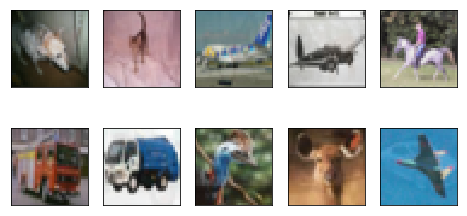

[(0, 'airplane'), (1, 'automobile'), (2, 'bird'), (3, 'cat'), (4, 'deer'), (5, 'dog'), (6, 'frog'), (7, 'horse'), (8, 'ship'), (9, 'truck')]

[[[ 0.          0.          0.          0.10898913  0.          0.89101088
    0.          0.          0.          0.        ]]

 [[ 0.          0.          0.          1.          0.          0.          0.
    0.          0.          0.        ]]

 [[ 0.89101088  0.          0.          0.          0.          0.          0.
    0.10898913  0.          0.        ]]

 [[ 0.89101088  0.          0.          0.          0.10898913  0.          0.
    0.          0.          0.        ]]

 [[ 0.          0.          0.          0.          0.          0.          0.
    0.89101088  0.          0.10898913]]

 [[ 0.          0.          0.          0.          0.          0.          0.
    0.          0.          1.        ]]

 [[ 0.          0.          0.          0.          0.          0.          0.
    0.          0.          1.        ]]

 [[

In [6]:
from cifar10_utils import show_images
%matplotlib inline
mean=np.array([0.4914, 0.4822, 0.4465])
std=np.array([0.2023, 0.1994, 0.2010])
images = data[:10].transpose((0, 2, 3, 1)).asnumpy()
images = images * std + mean
images = images.transpose((0, 3, 1, 2)) * 255
show_images(images)
#show_images(data[:9], rgb_mean=mean*255, std=std*255)

print [(i, l) for i, l in enumerate(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])]
print label[:10]

## 3.3 mixup: train

In [7]:
from time import time
mixup_test = False

if mixup_test:
    net = ResNet164_v2(10)
    net.collect_params().initialize(mx.init.Xavier(), ctx=ctx, force_reinit=True)
    loss_f = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)

    num_epochs = 1
    learning_rate = 0.1
    weight_decay = 1e-4

    cur_time = time()
    iters = 0
    """
    data loader first time run will cost about 3x time than after run.
    """
    for x1, y1 in train_data:
        if iters % 100 == 0:
            print iters, time() - cur_time
        iters += 1
    print "cost time:", time() - cur_time
    print
    cur_time = time()

    iters = 0
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'momentum': 0.9, 'wd': 1e-4})
    for x, y in train_data:
        l = x.shape[0] / 2
        data, label = mixup(x[:l], y[:l], x[l:2*l], y[l:2*l], mixup_alpha, 10)

        with autograd.record():
            output = net(data.as_in_context(ctx))
            loss = loss_f(output, label.as_in_context(ctx))
        loss.backward()
        trainer.step(data.shape[0])

        if iters % 100 == 0:
            print iters, time() - cur_time, nd.mean(loss).asscalar()
        iters += 1
    print iters, time() - cur_time

    # load data one by one batch
    # iters = 0
    # for x1, y1 in train_data:
    #     for x2, y2 in mixup_train_data:
    #         data, label = mixup(x1, y1, x2[:x1.shape[0]], y2[:y1.shape[0]], mixup_alpha, 10)
    #         break
    #     if iters % 100 == 0:
    #         print iters, time() - cur_time
    #     iters += 1
    # print "cost time:", time() - cur_time
    # print
    # cur_time = time()

    # zip will load all datas and then iterate them, too cost memory, will drop speed when memory over.
    # iters = 0
    # for (x1, y1), (x2, y2) in zip(train_data, mixup_train_data):
    #     data, label = mixup(x1, y1, x2, y2, mixup_alpha, 10)
    #     if iters % 100 == 0:
    #         print iters, time() - cur_time#, nd.mean(loss).asscalar()
    #     iters += 1
    # print time() - cur_time

# 4. define train function

In [8]:
"""
train
"""
import datetime
import utils
import sys

def abs_mean(W):
    return nd.mean(nd.abs(W)).asscalar()

def in_list(e, l):
    for i in l:
        if i == e:
            return True
    else:
        return False

def train(net, train_data, valid_data, num_epochs, lr, lr_period, 
          lr_decay, wd, ctx, w_key, output_file=None, verbose=False, loss_f=gluon.loss.SoftmaxCrossEntropyLoss(), 
          use_mixup=False, mixup_alpha=0.2):
    def train_batch(data, label, i):
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data.as_in_context(ctx))
            loss = loss_f(output, label)
        loss.backward()
        trainer.step(data.shape[0])

        _loss = nd.mean(loss).asscalar()
        if not use_mixup:
            _acc = utils.accuracy(output, label)
        else:
            _acc = None

        if verbose and i % 100 == 0:
            print " # iter", i,
            print "loss %.5f" % _loss, 
            if not use_mixup: print "acc %.5f" % _acc,
            print "w (",
            for k in w_key:
                w = net.collect_params()[k]
                print "%.5f, " % abs_mean(w.data()),
            print ") g (",
            for k in w_key:
                w = net.collect_params()[k]
                print "%.5f, " % abs_mean(w.grad()),
            print ")"
        return _loss, _acc
            
    if output_file is None:
        output_file = sys.stdout
        stdout = sys.stdout
    else:
        output_file = open(output_file, "w")
        stdout = sys.stdout
        sys.stdout = output_file
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr, 'momentum': 0.9, 'wd': wd})
    prev_time = datetime.datetime.now()
    
    if verbose:
        print " #", utils.evaluate_accuracy(valid_data, net, ctx)
    
    i = 0
    for epoch in range(num_epochs):
        train_loss = 0.
        train_acc = 0.
        if in_list(epoch, lr_period):
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
            
        if not use_mixup:
            for data, label in train_data:
                _loss, _acc = train_batch(data, label, i)
                train_loss += _loss
                train_acc += _acc
                i += 1
        else:
            for x, y in train_data:
                l = x.shape[0] / 2
                data, label = mixup(x[:l], y[:l], x[l:2*l], y[l:2*l], mixup_alpha, 10)
                _loss, _ = train_batch(data, label, i)
                train_loss += _loss
                i += 1
        
        cur_time = datetime.datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        
        train_loss /= len(train_data)
        train_acc /= len(train_data)
        if train_acc < 1e-6:
            train_acc = utils.evaluate_accuracy(train_data, net, ctx)
        
        if valid_data is not None:
            valid_acc = utils.evaluate_accuracy(valid_data, net, ctx)
            epoch_str = ("epoch %d, loss %.5f, train_acc %.4f, valid_acc %.4f" 
                         % (epoch, train_loss, train_acc, valid_acc))
        else:
            epoch_str = ("epoch %d, loss %.5f, train_acc %.4f"
                        % (epoch, train_loss, train_acc))
        prev_time = cur_time
        output_file.write(epoch_str + ", " + time_str + ",lr " + str(trainer.learning_rate) + "\n")
        output_file.flush()  # to disk only when flush or close
    if output_file != stdout:
        sys.stdout = stdout
        output_file.close()

# 5. get net and do EXP
```
I want to find out the reason that resnet18_v2 get fail baseline in CIFAR10_train2_* script, design follow exp.

1. 5.1 train my resnet18 to repreduce baseline(0.93 acc), to make sure code is no bugs.
2. 5.2 train gluon resnet18 use same hyper-param, get failed baseline(0.85 acc), so i thought the reason may cause by gluon resnet18 and my resnet18.
 there are three diff between them(I thought the diff may cause gluon resnet is design for imagenet and my gluon is design for CIFAR10):<br/>
    a. first conv use diff kernel size and padding size:conv(k=7,p=3,s=1) vs conv(k=3,p=1,s=1)
    b. after first block, gluon resnet18 use maxpool and my resnet not use
    c. gluon resnet18 use 4 * 2 block with channel size [64, 128, 256, 512] and three downsample, and my resnet18 use 3 * 3 block with channle size [32, 64, 128] and two downsample, so last layer use global avg pooling.
    it may said delay pooling is useful, pool to early is not good.
```


## 5.1 re-exp resnet18_v1
train my resnet18 to repreduce baseline(0.93 acc), to make sure code is no bugs.

In [9]:
net = ResNet(10)
net.load_params('../../models/res18_9', ctx=ctx)
valid_acc = utils.evaluate_accuracy(test_data, net, ctx)
print valid_acc
def get_net(ctx):
    num_outputs = 10
    net = ResNet(num_outputs)
    net.collect_params().initialize(init=init.Xavier(), ctx=ctx, force_reinit=True)
    return net  

0.932408146965


In [18]:
num_epochs = 80
learning_rate = 0.1
weight_decay = 5e-4
lr_period = [80]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=4)
net = get_net(ctx)
net.hybridize()
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f)

net.save_params("../../models/resnet18_me_80e_aug")

epoch 0, loss 1.80346, train_acc 0.3266, valid_acc 0.3598, Time 00:00:28,lr 0.1
epoch 1, loss 1.28281, train_acc 0.5411, valid_acc 0.5778, Time 00:00:31,lr 0.1
epoch 2, loss 1.01865, train_acc 0.6431, valid_acc 0.6533, Time 00:00:30,lr 0.1
epoch 3, loss 0.90869, train_acc 0.6870, valid_acc 0.5823, Time 00:00:30,lr 0.1
epoch 4, loss 0.85972, train_acc 0.7049, valid_acc 0.6255, Time 00:00:31,lr 0.1
epoch 5, loss 0.82922, train_acc 0.7158, valid_acc 0.6503, Time 00:00:31,lr 0.1
epoch 6, loss 0.81416, train_acc 0.7211, valid_acc 0.6621, Time 00:00:31,lr 0.1
epoch 7, loss 0.79129, train_acc 0.7286, valid_acc 0.6731, Time 00:00:31,lr 0.1
epoch 8, loss 0.79221, train_acc 0.7293, valid_acc 0.6960, Time 00:00:31,lr 0.1
epoch 9, loss 0.77941, train_acc 0.7357, valid_acc 0.7085, Time 00:00:30,lr 0.1
epoch 10, loss 0.77304, train_acc 0.7350, valid_acc 0.6773, Time 00:00:33,lr 0.1
epoch 11, loss 0.77300, train_acc 0.7362, valid_acc 0.6708, Time 00:00:32,lr 0.1
epoch 12, loss 0.77379, train_acc 0.73

In [10]:
num_epochs = 120
learning_rate = 0.05
weight_decay = 1e-3
lr_period = [30, 60, 90]
lr_decay=0.2
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

net = get_net(ctx)
net.load_params("../../models/resnet18_me_80e_aug", ctx=ctx)

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=4)
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f)
net.save_params('../../models/resnet18_me_9')

epoch 0, loss 0.61285, train_acc 0.7915, valid_acc 0.7278, Time 00:00:31,lr 0.05
epoch 1, loss 0.68711, train_acc 0.7663, valid_acc 0.6986, Time 00:00:31,lr 0.05
epoch 2, loss 0.70354, train_acc 0.7601, valid_acc 0.7469, Time 00:00:31,lr 0.05
epoch 3, loss 0.70402, train_acc 0.7604, valid_acc 0.6044, Time 00:00:31,lr 0.05
epoch 4, loss 0.70819, train_acc 0.7573, valid_acc 0.7099, Time 00:00:31,lr 0.05
epoch 5, loss 0.71752, train_acc 0.7569, valid_acc 0.7387, Time 00:00:31,lr 0.05
epoch 6, loss 0.71241, train_acc 0.7581, valid_acc 0.7282, Time 00:00:32,lr 0.05
epoch 7, loss 0.71346, train_acc 0.7582, valid_acc 0.7717, Time 00:00:32,lr 0.05
epoch 8, loss 0.71035, train_acc 0.7555, valid_acc 0.7430, Time 00:00:32,lr 0.05
epoch 9, loss 0.71255, train_acc 0.7570, valid_acc 0.7069, Time 00:00:32,lr 0.05
epoch 10, loss 0.71683, train_acc 0.7539, valid_acc 0.5970, Time 00:00:32,lr 0.05
epoch 11, loss 0.71341, train_acc 0.7572, valid_acc 0.7481, Time 00:00:31,lr 0.05
epoch 12, loss 0.71346, tr

epoch 100, loss 0.03685, train_acc 0.9899, valid_acc 0.9265, Time 00:00:31,lr 0.0004
epoch 101, loss 0.03604, train_acc 0.9903, valid_acc 0.9277, Time 00:00:31,lr 0.0004
epoch 102, loss 0.03277, train_acc 0.9917, valid_acc 0.9261, Time 00:00:31,lr 0.0004
epoch 103, loss 0.03316, train_acc 0.9913, valid_acc 0.9253, Time 00:00:32,lr 0.0004
epoch 104, loss 0.03211, train_acc 0.9920, valid_acc 0.9288, Time 00:00:31,lr 0.0004
epoch 105, loss 0.03214, train_acc 0.9913, valid_acc 0.9277, Time 00:00:32,lr 0.0004
epoch 106, loss 0.03095, train_acc 0.9922, valid_acc 0.9286, Time 00:00:31,lr 0.0004
epoch 107, loss 0.03007, train_acc 0.9922, valid_acc 0.9275, Time 00:00:31,lr 0.0004
epoch 108, loss 0.02834, train_acc 0.9926, valid_acc 0.9271, Time 00:00:31,lr 0.0004
epoch 109, loss 0.03008, train_acc 0.9920, valid_acc 0.9286, Time 00:00:31,lr 0.0004
epoch 110, loss 0.02855, train_acc 0.9928, valid_acc 0.9279, Time 00:00:31,lr 0.0004
epoch 111, loss 0.02935, train_acc 0.9926, valid_acc 0.9269, Time

## 5.2 use gluon renset18_v1
train gluon resnet18 use same hyper-param, get failed baseline(0.85 acc), so i thought the reason may cause by gluon resnet18 and my resnet18.

In [17]:
# create and add must in name_scope, or may got name error
def get_resnet18_v1(pretrained=True):
    net = nn.HybridSequential()
    with net.name_scope():
        resnet = model.resnet18_v1(pretrained=pretrained, ctx=ctx)
        output = nn.Dense(10)
        net.add(resnet.features)
        net.add(output)

    net.hybridize()
    if pretrained:
        output.initialize(ctx=ctx)
    else:
        net.initialize(ctx=ctx)
    return net

In [14]:
num_epochs = 80
learning_rate = 0.1
weight_decay = 5e-4
lr_period = [80]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=4)
net = get_resnet18_v1()
net.hybridize()
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f)

net.save_params("../../models/resnet18_v1_80e_aug")

epoch 0, loss 2.51019, train_acc 0.2129, valid_acc 0.3261, Time 00:00:27,lr 0.1
epoch 1, loss 1.75673, train_acc 0.3417, valid_acc 0.4151, Time 00:00:25,lr 0.1
epoch 2, loss 1.60616, train_acc 0.4121, valid_acc 0.4824, Time 00:00:24,lr 0.1
epoch 3, loss 1.49376, train_acc 0.4615, valid_acc 0.4921, Time 00:00:24,lr 0.1
epoch 4, loss 1.42743, train_acc 0.4928, valid_acc 0.4964, Time 00:00:25,lr 0.1
epoch 5, loss 1.37983, train_acc 0.5144, valid_acc 0.5435, Time 00:00:24,lr 0.1
epoch 6, loss 1.36243, train_acc 0.5234, valid_acc 0.5876, Time 00:00:25,lr 0.1
epoch 7, loss 1.33671, train_acc 0.5313, valid_acc 0.5255, Time 00:00:25,lr 0.1
epoch 8, loss 1.31173, train_acc 0.5461, valid_acc 0.5368, Time 00:00:24,lr 0.1
epoch 9, loss 1.27490, train_acc 0.5587, valid_acc 0.5911, Time 00:00:24,lr 0.1
epoch 10, loss 1.27032, train_acc 0.5597, valid_acc 0.6087, Time 00:00:28,lr 0.1
epoch 11, loss 1.25436, train_acc 0.5670, valid_acc 0.5886, Time 00:00:24,lr 0.1
epoch 12, loss 1.24745, train_acc 0.56

In [16]:
num_epochs = 120
learning_rate = 0.05
weight_decay = 1e-3
lr_period = [30, 60, 90]
lr_decay=0.2
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

net = get_resnet18_v1()
net.load_params("../../models/resnet18_v1_80e_aug", ctx=ctx)

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=4)
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f)
net.save_params('../../models/resnet18_v1_9')

epoch 0, loss 1.03273, train_acc 0.6475, valid_acc 0.6599, Time 00:00:24,lr 0.05
epoch 1, loss 1.10147, train_acc 0.6258, valid_acc 0.6101, Time 00:00:24,lr 0.05
epoch 2, loss 1.10971, train_acc 0.6221, valid_acc 0.6303, Time 00:00:24,lr 0.05
epoch 3, loss 1.11335, train_acc 0.6201, valid_acc 0.6158, Time 00:00:24,lr 0.05
epoch 4, loss 1.11669, train_acc 0.6186, valid_acc 0.6162, Time 00:00:24,lr 0.05
epoch 5, loss 1.10626, train_acc 0.6214, valid_acc 0.6486, Time 00:00:24,lr 0.05
epoch 6, loss 1.11353, train_acc 0.6192, valid_acc 0.6361, Time 00:00:24,lr 0.05
epoch 7, loss 1.10059, train_acc 0.6249, valid_acc 0.6364, Time 00:00:24,lr 0.05
epoch 8, loss 1.11230, train_acc 0.6210, valid_acc 0.6317, Time 00:00:24,lr 0.05
epoch 9, loss 1.10704, train_acc 0.6200, valid_acc 0.5400, Time 00:00:24,lr 0.05
epoch 10, loss 1.10685, train_acc 0.6223, valid_acc 0.6251, Time 00:00:24,lr 0.05
epoch 11, loss 1.11229, train_acc 0.6209, valid_acc 0.6055, Time 00:00:24,lr 0.05
epoch 12, loss 1.11007, tr

epoch 100, loss 0.27405, train_acc 0.9057, valid_acc 0.8599, Time 00:00:26,lr 0.0004
epoch 101, loss 0.27207, train_acc 0.9066, valid_acc 0.8568, Time 00:00:25,lr 0.0004
epoch 102, loss 0.27203, train_acc 0.9067, valid_acc 0.8584, Time 00:00:25,lr 0.0004
epoch 103, loss 0.26894, train_acc 0.9070, valid_acc 0.8580, Time 00:00:27,lr 0.0004
epoch 104, loss 0.26925, train_acc 0.9077, valid_acc 0.8566, Time 00:00:25,lr 0.0004
epoch 105, loss 0.26636, train_acc 0.9088, valid_acc 0.8558, Time 00:00:24,lr 0.0004
epoch 106, loss 0.26520, train_acc 0.9085, valid_acc 0.8559, Time 00:00:26,lr 0.0004
epoch 107, loss 0.26192, train_acc 0.9094, valid_acc 0.8562, Time 00:00:27,lr 0.0004
epoch 108, loss 0.26339, train_acc 0.9091, valid_acc 0.8547, Time 00:00:25,lr 0.0004
epoch 109, loss 0.26113, train_acc 0.9096, valid_acc 0.8568, Time 00:00:24,lr 0.0004
epoch 110, loss 0.25569, train_acc 0.9102, valid_acc 0.8575, Time 00:00:24,lr 0.0004
epoch 111, loss 0.25539, train_acc 0.9117, valid_acc 0.8565, Time

### 5.2.1 gluon resnet18 vs my resnet18
```
there are three diff between them(I thought the diff may cause gluon resnet is design for imagenet and my gluon is design for CIFAR10):<br/>
    a. first conv use diff kernel size and padding size:conv(k=7,p=3,s=1) vs conv(k=3,p=1,s=1)
    b. after first block, gluon resnet18 use maxpool and my resnet not use
    c. gluon resnet18 use 4 * 2 block with channel size [64, 128, 256, 512] and three downsample, and my resnet18 use 3 * 3 block with channle size [32, 64, 128] and two downsample, so last layer use global avg pooling.
    it may said delay pooling is useful, pool to early is not good.
```

In [22]:
net1 = ResNet(10)
'''
block1: conv(32, 3, 1, 1) + BN + relu
block2: Residual_block(32) * 3
block3: Resisual_block(64) * 3
block4: Residual_block(128) * 3
block5: AvgPool(8) + Flatten + Dense(10)

actually it has 19 conv + 1 fc, some code name it as resnet20 (each Residual_block has 2 conv or 2 + 1 conv(two line))
for cifar10 dataset, most code use this arch (https://github.com/yinglang/pytorch-cifar-models).
'''
net2 = get_resnet18_v1()
'''
block1: conv(64, 7, 3, 2) + BN + relu + MaxPool(3, 1, 2)
block2: Residual_block(64) * 2
block3: Resisual_block(128) * 2
block4: Residual_block(256) * 2
block5: Residual_block(256) * 2
block6: GlobalAvgPool() + Dense(10) 

has 1 + (2 + 2 + 2 + 2) * 2 = 15 conv + 1 fc, name it as resnet18
'''
print net1

ResNet(
  (net): HybridSequential(
    (0): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm(fix_gamma=False, use_global_stats=False, eps=1e-05, momentum=0.9, axis=1, in_channels=None)
    (2): Activation(relu)
    (3): Residual(
      (bn1): BatchNorm(fix_gamma=False, use_global_stats=False, eps=1e-05, momentum=0.9, axis=1, in_channels=None)
      (bn2): BatchNorm(fix_gamma=False, use_global_stats=False, eps=1e-05, momentum=0.9, axis=1, in_channels=None)
      (conv2): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv1): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (4): Residual(
      (bn1): BatchNorm(fix_gamma=False, use_global_stats=False, eps=1e-05, momentum=0.9, axis=1, in_channels=None)
      (bn2): BatchNorm(fix_gamma=False, use_global_stats=False, eps=1e-05, momentum=0.9, axis=1, in_channels=None)
      (conv2): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), paddin

In [18]:
print net2

HybridSequential(
  (0): HybridSequential(
    (0): Conv2D(3 -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm(fix_gamma=False, use_global_stats=False, eps=1e-05, momentum=0.9, axis=1, in_channels=64)
    (2): Activation(relu)
    (3): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False)
    (4): HybridSequential(
      (0): BasicBlockV1(
        (body): HybridSequential(
          (0): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm(fix_gamma=False, use_global_stats=False, eps=1e-05, momentum=0.9, axis=1, in_channels=64)
          (2): Activation(relu)
          (3): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm(fix_gamma=False, use_global_stats=False, eps=1e-05, momentum=0.9, axis=1, in_channels=64)
        )
      )
      (1): BasicBlockV1(
        (body): HybridSequential(
          (0): Conv2D(64 -> 64, kernel_

## 5.3 gluon resnet18 vs my resnet 18: first conv is conv(k=7,p=3,s=2) vs conv(k=3,p=1,s=1)

In [9]:
def get_resnet18_v1_3x3(pretrained=True):
    net = nn.HybridSequential()
    with net.name_scope():
        resnet = model.resnet18_v1(pretrained=pretrained, ctx=ctx)
        conv1 = nn.Conv2D(64, kernel_size=3, strides=1, padding=1, use_bias=False)
        output = nn.Dense(10)
        net.add(conv1)
        net.add(*resnet.features[1:])
        net.add(output)

    net.hybridize()
    if pretrained:
        conv1.initialize(ctx=ctx)
        output.initialize(ctx=ctx)
    else:
        net.initialize(ctx=ctx)
    return net

In [10]:
num_epochs = 80
learning_rate = 0.1
weight_decay = 5e-4
lr_period = [80]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=4)
net = get_resnet18_v1_3x3()
net.hybridize()
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f)

net.save_params("../../models/resnet18_v1_80e_aug_3x3")

epoch 0, loss 2.20239, train_acc 0.2669, valid_acc 0.3902, Time 00:00:32,lr 0.1
epoch 1, loss 1.65517, train_acc 0.3912, valid_acc 0.4528, Time 00:00:33,lr 0.1
epoch 2, loss 1.47576, train_acc 0.4642, valid_acc 0.4337, Time 00:00:33,lr 0.1
epoch 3, loss 1.34809, train_acc 0.5176, valid_acc 0.5469, Time 00:00:30,lr 0.1
epoch 4, loss 1.25687, train_acc 0.5574, valid_acc 0.5480, Time 00:00:30,lr 0.1
epoch 5, loss 1.20031, train_acc 0.5783, valid_acc 0.5777, Time 00:00:30,lr 0.1
epoch 6, loss 1.15576, train_acc 0.5958, valid_acc 0.6329, Time 00:00:30,lr 0.1
epoch 7, loss 1.11209, train_acc 0.6100, valid_acc 0.6637, Time 00:00:30,lr 0.1
epoch 8, loss 1.06140, train_acc 0.6298, valid_acc 0.5927, Time 00:00:30,lr 0.1
epoch 9, loss 1.02432, train_acc 0.6445, valid_acc 0.6795, Time 00:00:30,lr 0.1
epoch 10, loss 1.00051, train_acc 0.6551, valid_acc 0.6433, Time 00:00:31,lr 0.1
epoch 11, loss 0.98188, train_acc 0.6637, valid_acc 0.6974, Time 00:00:30,lr 0.1
epoch 12, loss 0.96989, train_acc 0.66

In [12]:
num_epochs = 120
learning_rate = 0.05
weight_decay = 1e-3
lr_period = [30, 60, 90]
lr_decay=0.2
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

net = get_resnet18_v1_3x3()
net.load_params("../../models/resnet18_v1_80e_aug_3x3", ctx=ctx)

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=4)
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f)
net.save_params('../../models/resnet18_v1_9_3x3')

epoch 0, loss 0.77403, train_acc 0.7361, valid_acc 0.6271, Time 00:00:28,lr 0.05
epoch 1, loss 0.84400, train_acc 0.7124, valid_acc 0.6732, Time 00:00:30,lr 0.05
epoch 2, loss 0.86126, train_acc 0.7060, valid_acc 0.7009, Time 00:00:30,lr 0.05
epoch 3, loss 0.86573, train_acc 0.7063, valid_acc 0.6787, Time 00:00:30,lr 0.05
epoch 4, loss 0.85972, train_acc 0.7096, valid_acc 0.6623, Time 00:00:30,lr 0.05
epoch 5, loss 0.86412, train_acc 0.7051, valid_acc 0.6821, Time 00:00:31,lr 0.05
epoch 6, loss 0.86789, train_acc 0.7018, valid_acc 0.6822, Time 00:00:31,lr 0.05
epoch 7, loss 0.86329, train_acc 0.7054, valid_acc 0.6411, Time 00:00:31,lr 0.05
epoch 8, loss 0.87379, train_acc 0.7028, valid_acc 0.7026, Time 00:00:31,lr 0.05
epoch 9, loss 0.86685, train_acc 0.7050, valid_acc 0.6352, Time 00:00:31,lr 0.05
epoch 10, loss 0.86982, train_acc 0.7020, valid_acc 0.6822, Time 00:00:32,lr 0.05
epoch 11, loss 0.86871, train_acc 0.7042, valid_acc 0.5869, Time 00:00:31,lr 0.05
epoch 12, loss 0.86923, tr

epoch 100, loss 0.10466, train_acc 0.9656, valid_acc 0.9050, Time 00:00:31,lr 0.0004
epoch 101, loss 0.09925, train_acc 0.9674, valid_acc 0.9043, Time 00:00:31,lr 0.0004
epoch 102, loss 0.09841, train_acc 0.9671, valid_acc 0.9091, Time 00:00:31,lr 0.0004
epoch 103, loss 0.09499, train_acc 0.9692, valid_acc 0.9091, Time 00:00:31,lr 0.0004
epoch 104, loss 0.09518, train_acc 0.9685, valid_acc 0.9089, Time 00:00:31,lr 0.0004
epoch 105, loss 0.09390, train_acc 0.9696, valid_acc 0.9105, Time 00:00:31,lr 0.0004
epoch 106, loss 0.09006, train_acc 0.9702, valid_acc 0.9070, Time 00:00:32,lr 0.0004
epoch 107, loss 0.09035, train_acc 0.9709, valid_acc 0.9081, Time 00:00:31,lr 0.0004
epoch 108, loss 0.08887, train_acc 0.9702, valid_acc 0.9073, Time 00:00:33,lr 0.0004
epoch 109, loss 0.08896, train_acc 0.9715, valid_acc 0.9060, Time 00:00:31,lr 0.0004
epoch 110, loss 0.08627, train_acc 0.9710, valid_acc 0.9103, Time 00:00:31,lr 0.0004
epoch 111, loss 0.08818, train_acc 0.9706, valid_acc 0.9070, Time

## 5.3.2 I wanto find out acc impove may from cancel downsample, so use k=7 but not downsmaple and k=3 but downsample to try

In [9]:
def get_resnet18_v1_k7p3s1(pretrained=True):
    net = nn.HybridSequential()
    with net.name_scope():
        resnet = model.resnet18_v1(pretrained=pretrained, ctx=ctx)
        conv1 = nn.Conv2D(64, kernel_size=7, strides=1, padding=3, use_bias=False)
        output = nn.Dense(10)
        net.add(conv1)
        net.add(*resnet.features[1:])
        net.add(output)

    net.hybridize()
    if pretrained:
        conv1.initialize(ctx=ctx)
        output.initialize(ctx=ctx)
    else:
        net.initialize(ctx=ctx)
    return net

In [10]:
num_epochs = 80
learning_rate = 0.1
weight_decay = 5e-4
lr_period = [80]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=4)
net = get_resnet18_v1_k7p3s1()
net.hybridize()
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f)

num_epochs = 120
learning_rate = 0.05
weight_decay = 1e-3
lr_period = [30, 60, 90]
lr_decay=0.2

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=4)
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f)
net.save_params('../../models/resnet18_v1_k7p3s1')

epoch 0, loss 2.30376, train_acc 0.2260, valid_acc 0.3361, Time 00:00:31,lr 0.1
epoch 1, loss 1.68781, train_acc 0.3729, valid_acc 0.4189, Time 00:00:35,lr 0.1
epoch 2, loss 1.52445, train_acc 0.4432, valid_acc 0.5236, Time 00:00:32,lr 0.1
epoch 3, loss 1.37861, train_acc 0.5034, valid_acc 0.5116, Time 00:00:32,lr 0.1
epoch 4, loss 1.29522, train_acc 0.5379, valid_acc 0.5644, Time 00:00:32,lr 0.1
epoch 5, loss 1.23774, train_acc 0.5634, valid_acc 0.5271, Time 00:00:31,lr 0.1
epoch 6, loss 1.18491, train_acc 0.5845, valid_acc 0.6008, Time 00:00:32,lr 0.1
epoch 7, loss 1.13172, train_acc 0.6043, valid_acc 0.6084, Time 00:00:32,lr 0.1
epoch 8, loss 1.10778, train_acc 0.6163, valid_acc 0.6573, Time 00:00:33,lr 0.1
epoch 9, loss 1.06816, train_acc 0.6311, valid_acc 0.6118, Time 00:00:32,lr 0.1
epoch 10, loss 1.03542, train_acc 0.6430, valid_acc 0.6466, Time 00:00:32,lr 0.1
epoch 11, loss 1.02805, train_acc 0.6471, valid_acc 0.6633, Time 00:00:32,lr 0.1
epoch 12, loss 1.01376, train_acc 0.65

epoch 22, loss 0.91377, train_acc 0.6874, valid_acc 0.7030, Time 00:00:32,lr 0.05
epoch 23, loss 0.91145, train_acc 0.6884, valid_acc 0.6387, Time 00:00:32,lr 0.05
epoch 24, loss 0.91180, train_acc 0.6891, valid_acc 0.7214, Time 00:00:32,lr 0.05
epoch 25, loss 0.91215, train_acc 0.6880, valid_acc 0.6815, Time 00:00:32,lr 0.05
epoch 26, loss 0.90945, train_acc 0.6892, valid_acc 0.6991, Time 00:00:32,lr 0.05
epoch 27, loss 0.91134, train_acc 0.6903, valid_acc 0.6897, Time 00:00:32,lr 0.05
epoch 28, loss 0.91023, train_acc 0.6889, valid_acc 0.6460, Time 00:00:32,lr 0.05
epoch 29, loss 0.90890, train_acc 0.6892, valid_acc 0.6105, Time 00:00:32,lr 0.05
epoch 30, loss 0.62314, train_acc 0.7879, valid_acc 0.8119, Time 00:00:32,lr 0.01
epoch 31, loss 0.57048, train_acc 0.8056, valid_acc 0.8057, Time 00:00:32,lr 0.01
epoch 32, loss 0.56539, train_acc 0.8086, valid_acc 0.8094, Time 00:00:32,lr 0.01
epoch 33, loss 0.56050, train_acc 0.8097, valid_acc 0.8174, Time 00:00:32,lr 0.01
epoch 34, loss 0

In [11]:
def get_resnet18_v1_k3p1s2(pretrained=True):
    net = nn.HybridSequential()
    with net.name_scope():
        resnet = model.resnet18_v1(pretrained=pretrained, ctx=ctx)
        conv1 = nn.Conv2D(64, kernel_size=3, strides=2, padding=1, use_bias=False)
        output = nn.Dense(10)
        net.add(conv1)
        net.add(*resnet.features[1:])
        net.add(output)

    net.hybridize()
    if pretrained:
        conv1.initialize(ctx=ctx)
        output.initialize(ctx=ctx)
    else:
        net.initialize(ctx=ctx)
    return net

In [12]:
num_epochs = 80
learning_rate = 0.1
weight_decay = 5e-4
lr_period = [80]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=4)
net = get_resnet18_v1_k3p1s2()
net.hybridize()
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f)

num_epochs = 120
learning_rate = 0.05
weight_decay = 1e-3
lr_period = [30, 60, 90]
lr_decay=0.2

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=4)
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f)
net.save_params('../../models/resnet18_v1_k3p1s2')

epoch 0, loss 2.50262, train_acc 0.2350, valid_acc 0.3242, Time 00:00:23,lr 0.1
epoch 1, loss 1.78462, train_acc 0.3364, valid_acc 0.4290, Time 00:00:24,lr 0.1
epoch 2, loss 1.62260, train_acc 0.4035, valid_acc 0.4589, Time 00:00:24,lr 0.1
epoch 3, loss 1.54967, train_acc 0.4401, valid_acc 0.4553, Time 00:00:25,lr 0.1
epoch 4, loss 1.47895, train_acc 0.4708, valid_acc 0.4980, Time 00:00:28,lr 0.1
epoch 5, loss 1.42545, train_acc 0.4961, valid_acc 0.5139, Time 00:00:25,lr 0.1
epoch 6, loss 1.38317, train_acc 0.5145, valid_acc 0.5491, Time 00:00:25,lr 0.1
epoch 7, loss 1.33647, train_acc 0.5331, valid_acc 0.5664, Time 00:00:26,lr 0.1
epoch 8, loss 1.30906, train_acc 0.5418, valid_acc 0.5851, Time 00:00:26,lr 0.1
epoch 9, loss 1.29921, train_acc 0.5507, valid_acc 0.5837, Time 00:00:25,lr 0.1
epoch 10, loss 1.28389, train_acc 0.5545, valid_acc 0.5244, Time 00:00:26,lr 0.1
epoch 11, loss 1.25926, train_acc 0.5661, valid_acc 0.5465, Time 00:00:25,lr 0.1
epoch 12, loss 1.25738, train_acc 0.56

epoch 22, loss 1.11496, train_acc 0.6212, valid_acc 0.6180, Time 00:00:24,lr 0.05
epoch 23, loss 1.11273, train_acc 0.6213, valid_acc 0.6098, Time 00:00:24,lr 0.05
epoch 24, loss 1.11474, train_acc 0.6186, valid_acc 0.6466, Time 00:00:24,lr 0.05
epoch 25, loss 1.11465, train_acc 0.6209, valid_acc 0.6061, Time 00:00:24,lr 0.05
epoch 26, loss 1.11365, train_acc 0.6206, valid_acc 0.6113, Time 00:00:25,lr 0.05
epoch 27, loss 1.11495, train_acc 0.6179, valid_acc 0.5848, Time 00:00:26,lr 0.05
epoch 28, loss 1.10766, train_acc 0.6230, valid_acc 0.6258, Time 00:00:25,lr 0.05
epoch 29, loss 1.11466, train_acc 0.6197, valid_acc 0.6257, Time 00:00:24,lr 0.05
epoch 30, loss 0.83832, train_acc 0.7133, valid_acc 0.7441, Time 00:00:24,lr 0.01
epoch 31, loss 0.77775, train_acc 0.7343, valid_acc 0.7425, Time 00:00:24,lr 0.01
epoch 32, loss 0.78149, train_acc 0.7322, valid_acc 0.7436, Time 00:00:25,lr 0.01
epoch 33, loss 0.77605, train_acc 0.7342, valid_acc 0.7492, Time 00:00:24,lr 0.01
epoch 34, loss 0

## 5.4 gluon resnet18 vs my resnet 18: use max pooling vs no max pooling

In [11]:
def get_resnet18_v1_3x3_no_maxpool(pretrained=True):
    net = nn.HybridSequential()
    with net.name_scope():
        resnet = model.resnet18_v1(pretrained=pretrained, ctx=ctx)
        conv1 = nn.Conv2D(64, kernel_size=3, strides=1, padding=1, use_bias=False)
        output = nn.Dense(10)
        net.add(conv1)
        net.add(*resnet.features[1:3])
        net.add(*resnet.features[4:])
        net.add(output)

    net.hybridize()
    if pretrained:
        conv1.initialize(ctx=ctx)
        output.initialize(ctx=ctx)
    else:
        net.initialize(ctx=ctx)
    return net

In [15]:
num_epochs = 80
learning_rate = 0.1
weight_decay = 5e-4
lr_period = [80]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=4)
net = get_resnet18_v1_3x3_no_maxpool()
net.hybridize()
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f)

net.save_params("../../models/resnet18_v1_80e_aug_3x3_no_max_pool")

epoch 0, loss 2.38056, train_acc 0.1657, valid_acc 0.2737, Time 00:00:56,lr 0.1
epoch 1, loss 1.72326, train_acc 0.3529, valid_acc 0.3568, Time 00:00:57,lr 0.1
epoch 2, loss 1.41782, train_acc 0.4814, valid_acc 0.5539, Time 00:00:56,lr 0.1
epoch 3, loss 1.18895, train_acc 0.5769, valid_acc 0.4499, Time 00:00:56,lr 0.1
epoch 4, loss 1.06284, train_acc 0.6269, valid_acc 0.6079, Time 00:00:56,lr 0.1
epoch 5, loss 0.94214, train_acc 0.6724, valid_acc 0.6066, Time 00:00:56,lr 0.1
epoch 6, loss 0.88145, train_acc 0.6946, valid_acc 0.5705, Time 00:00:57,lr 0.1
epoch 7, loss 0.84403, train_acc 0.7099, valid_acc 0.5912, Time 00:00:56,lr 0.1
epoch 8, loss 0.81196, train_acc 0.7204, valid_acc 0.7287, Time 00:00:56,lr 0.1
epoch 9, loss 0.79473, train_acc 0.7280, valid_acc 0.6951, Time 00:00:56,lr 0.1
epoch 10, loss 0.78191, train_acc 0.7316, valid_acc 0.6971, Time 00:00:56,lr 0.1
epoch 11, loss 0.77675, train_acc 0.7329, valid_acc 0.7301, Time 00:00:56,lr 0.1
epoch 12, loss 0.75665, train_acc 0.74

In [11]:
num_epochs = 120
learning_rate = 0.05
weight_decay = 1e-3
lr_period = [30, 60, 90]
lr_decay=0.2
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

net = get_resnet18_v1_3x3_no_maxpool()
net.load_params("../../models/resnet18_v1_80e_aug_3x3_no_max_pool", ctx=ctx)
net.hybridize()

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=4)
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f)
net.save_params('../../models/resnet18_v1_9_3x3_no_max_pool')

epoch 0, loss 0.58195, train_acc 0.8029, valid_acc 0.7700, Time 00:00:52,lr 0.05
epoch 1, loss 0.65821, train_acc 0.7764, valid_acc 0.7590, Time 00:00:55,lr 0.05
epoch 2, loss 0.68045, train_acc 0.7693, valid_acc 0.4827, Time 00:00:56,lr 0.05
epoch 3, loss 0.68091, train_acc 0.7667, valid_acc 0.7464, Time 00:00:56,lr 0.05
epoch 4, loss 0.68455, train_acc 0.7671, valid_acc 0.7237, Time 00:00:56,lr 0.05
epoch 5, loss 0.68415, train_acc 0.7694, valid_acc 0.7485, Time 00:00:57,lr 0.05
epoch 6, loss 0.68346, train_acc 0.7678, valid_acc 0.5743, Time 00:00:58,lr 0.05
epoch 7, loss 0.68119, train_acc 0.7682, valid_acc 0.6967, Time 00:00:56,lr 0.05
epoch 8, loss 0.68399, train_acc 0.7670, valid_acc 0.6504, Time 00:00:58,lr 0.05
epoch 9, loss 0.68451, train_acc 0.7676, valid_acc 0.6430, Time 00:00:57,lr 0.05
epoch 10, loss 0.68556, train_acc 0.7673, valid_acc 0.6783, Time 00:00:59,lr 0.05
epoch 11, loss 0.68058, train_acc 0.7669, valid_acc 0.6660, Time 00:00:57,lr 0.05
epoch 12, loss 0.69183, tr

epoch 100, loss 0.02084, train_acc 0.9946, valid_acc 0.9337, Time 00:00:57,lr 0.0004
epoch 101, loss 0.01851, train_acc 0.9954, valid_acc 0.9360, Time 00:00:58,lr 0.0004
epoch 102, loss 0.01870, train_acc 0.9954, valid_acc 0.9357, Time 00:00:56,lr 0.0004
epoch 103, loss 0.01807, train_acc 0.9956, valid_acc 0.9343, Time 00:00:57,lr 0.0004
epoch 104, loss 0.01849, train_acc 0.9954, valid_acc 0.9336, Time 00:00:56,lr 0.0004
epoch 105, loss 0.01738, train_acc 0.9961, valid_acc 0.9343, Time 00:00:57,lr 0.0004
epoch 106, loss 0.01575, train_acc 0.9961, valid_acc 0.9359, Time 00:01:01,lr 0.0004
epoch 107, loss 0.01618, train_acc 0.9963, valid_acc 0.9350, Time 00:00:56,lr 0.0004
epoch 108, loss 0.01708, train_acc 0.9954, valid_acc 0.9334, Time 00:00:56,lr 0.0004
epoch 109, loss 0.01544, train_acc 0.9964, valid_acc 0.9364, Time 00:00:56,lr 0.0004
epoch 110, loss 0.01496, train_acc 0.9965, valid_acc 0.9346, Time 00:00:57,lr 0.0004
epoch 111, loss 0.01420, train_acc 0.9966, valid_acc 0.9355, Time

## 5.5 general lr policy train resnet18_v1

In [12]:
num_epochs = 200
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [80, 150]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=4)
net = get_resnet18_v1_3x3_no_maxpool()
net.hybridize()
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f)

net.save_params("../../models/resnet18_v1_200e")

epoch 0, loss 2.15846, train_acc 0.2636, valid_acc 0.3974, Time 00:00:50,lr 0.1
epoch 1, loss 1.62803, train_acc 0.3977, valid_acc 0.4551, Time 00:00:54,lr 0.1
epoch 2, loss 1.41918, train_acc 0.4863, valid_acc 0.5159, Time 00:00:55,lr 0.1
epoch 3, loss 1.19825, train_acc 0.5719, valid_acc 0.6059, Time 00:00:56,lr 0.1
epoch 4, loss 1.01131, train_acc 0.6444, valid_acc 0.6491, Time 00:00:56,lr 0.1
epoch 5, loss 0.88996, train_acc 0.6878, valid_acc 0.7103, Time 00:00:56,lr 0.1
epoch 6, loss 0.78305, train_acc 0.7267, valid_acc 0.7235, Time 00:00:57,lr 0.1
epoch 7, loss 0.69410, train_acc 0.7577, valid_acc 0.7858, Time 00:00:56,lr 0.1
epoch 8, loss 0.63683, train_acc 0.7805, valid_acc 0.7856, Time 00:00:56,lr 0.1
epoch 9, loss 0.60257, train_acc 0.7929, valid_acc 0.7577, Time 00:00:56,lr 0.1
epoch 10, loss 0.57003, train_acc 0.8039, valid_acc 0.7868, Time 00:00:56,lr 0.1
epoch 11, loss 0.54821, train_acc 0.8109, valid_acc 0.8210, Time 00:00:56,lr 0.1
epoch 12, loss 0.52209, train_acc 0.81

epoch 101, loss 0.03337, train_acc 0.9887, valid_acc 0.9390, Time 00:00:56,lr 0.01
epoch 102, loss 0.03445, train_acc 0.9890, valid_acc 0.9373, Time 00:00:56,lr 0.01
epoch 103, loss 0.03368, train_acc 0.9888, valid_acc 0.9336, Time 00:00:56,lr 0.01
epoch 104, loss 0.03256, train_acc 0.9898, valid_acc 0.9330, Time 00:00:56,lr 0.01
epoch 105, loss 0.03219, train_acc 0.9896, valid_acc 0.9352, Time 00:00:56,lr 0.01
epoch 106, loss 0.03368, train_acc 0.9877, valid_acc 0.9321, Time 00:00:56,lr 0.01
epoch 107, loss 0.03187, train_acc 0.9894, valid_acc 0.9285, Time 00:00:56,lr 0.01
epoch 108, loss 0.03688, train_acc 0.9875, valid_acc 0.9326, Time 00:00:56,lr 0.01
epoch 109, loss 0.03780, train_acc 0.9873, valid_acc 0.9341, Time 00:00:56,lr 0.01
epoch 110, loss 0.03586, train_acc 0.9875, valid_acc 0.9356, Time 00:00:56,lr 0.01
epoch 111, loss 0.03375, train_acc 0.9887, valid_acc 0.9339, Time 00:00:56,lr 0.01
epoch 112, loss 0.03716, train_acc 0.9871, valid_acc 0.9310, Time 00:00:56,lr 0.01
epoc

## 5.6 general lr policy train resnet18_v2

In [13]:
def get_resnet18_v2_3x3_no_maxpool(pretrained=True):
    net = nn.HybridSequential()
    with net.name_scope():
        resnet = model.resnet18_v2(pretrained=pretrained, ctx=ctx)
        conv1 = nn.Conv2D(64, kernel_size=3, strides=1, padding=1, use_bias=False)
        output = nn.Dense(10)
        net.add(resnet.features[0])
        net.add(conv1)
        net.add(*resnet.features[2:4])
        net.add(*resnet.features[5:])
        net.add(output)

    net.hybridize()
    if pretrained:
        conv1.initialize(ctx=ctx)
        output.initialize(ctx=ctx)
    else:
        net.initialize(ctx=ctx)
    return net

In [14]:
num_epochs = 200
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [80, 150]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=4)
net = get_resnet18_v2_3x3_no_maxpool()
net.hybridize()
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f)

net.save_params("../../models/resnet18_v2_200e")

epoch 0, loss 2.44951, train_acc 0.1700, valid_acc 0.2141, Time 00:00:52,lr 0.1
epoch 1, loss 1.86926, train_acc 0.2854, valid_acc 0.3249, Time 00:00:56,lr 0.1
epoch 2, loss 1.68936, train_acc 0.3693, valid_acc 0.4108, Time 00:00:56,lr 0.1
epoch 3, loss 1.49349, train_acc 0.4522, valid_acc 0.4833, Time 00:00:56,lr 0.1
epoch 4, loss 1.28756, train_acc 0.5355, valid_acc 0.4992, Time 00:00:56,lr 0.1
epoch 5, loss 1.08968, train_acc 0.6136, valid_acc 0.6383, Time 00:00:56,lr 0.1
epoch 6, loss 0.91630, train_acc 0.6771, valid_acc 0.6946, Time 00:00:56,lr 0.1
epoch 7, loss 0.79485, train_acc 0.7227, valid_acc 0.7397, Time 00:00:56,lr 0.1
epoch 8, loss 0.71892, train_acc 0.7512, valid_acc 0.7302, Time 00:00:56,lr 0.1
epoch 9, loss 0.66048, train_acc 0.7693, valid_acc 0.7255, Time 00:00:56,lr 0.1
epoch 10, loss 0.62220, train_acc 0.7848, valid_acc 0.7608, Time 00:00:56,lr 0.1
epoch 11, loss 0.59447, train_acc 0.7961, valid_acc 0.7898, Time 00:00:56,lr 0.1
epoch 12, loss 0.56015, train_acc 0.80

epoch 101, loss 0.03855, train_acc 0.9868, valid_acc 0.9370, Time 00:00:56,lr 0.01
epoch 102, loss 0.03788, train_acc 0.9867, valid_acc 0.9364, Time 00:00:56,lr 0.01
epoch 103, loss 0.03558, train_acc 0.9879, valid_acc 0.9353, Time 00:00:56,lr 0.01
epoch 104, loss 0.03517, train_acc 0.9886, valid_acc 0.9349, Time 00:00:56,lr 0.01
epoch 105, loss 0.03818, train_acc 0.9870, valid_acc 0.9386, Time 00:00:56,lr 0.01
epoch 106, loss 0.03449, train_acc 0.9884, valid_acc 0.9323, Time 00:00:56,lr 0.01
epoch 107, loss 0.03584, train_acc 0.9881, valid_acc 0.9361, Time 00:00:56,lr 0.01
epoch 108, loss 0.03502, train_acc 0.9877, valid_acc 0.9363, Time 00:00:56,lr 0.01
epoch 109, loss 0.03759, train_acc 0.9875, valid_acc 0.9258, Time 00:00:56,lr 0.01
epoch 110, loss 0.03876, train_acc 0.9870, valid_acc 0.9316, Time 00:00:56,lr 0.01
epoch 111, loss 0.03911, train_acc 0.9871, valid_acc 0.9317, Time 00:00:56,lr 0.01
epoch 112, loss 0.03818, train_acc 0.9868, valid_acc 0.9322, Time 00:00:56,lr 0.01
epoc

## 5.7 general lr policy train my resnet18v1

In [9]:
num_epochs = 200
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [80, 150]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=4)
net = ResNet(10)
net.initialize(ctx=ctx)
net.hybridize()
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f)

net.save_params("../../models/resnet18_me_200e")

epoch 0, loss 1.75249, train_acc 0.3416, valid_acc 0.4678, Time 00:00:31,lr 0.1
epoch 1, loss 1.23604, train_acc 0.5568, valid_acc 0.5724, Time 00:00:32,lr 0.1
epoch 2, loss 0.93259, train_acc 0.6715, valid_acc 0.7011, Time 00:00:32,lr 0.1
epoch 3, loss 0.78639, train_acc 0.7277, valid_acc 0.6987, Time 00:00:30,lr 0.1
epoch 4, loss 0.68671, train_acc 0.7642, valid_acc 0.7434, Time 00:00:30,lr 0.1
epoch 5, loss 0.62936, train_acc 0.7856, valid_acc 0.7396, Time 00:00:30,lr 0.1
epoch 6, loss 0.59543, train_acc 0.7951, valid_acc 0.7949, Time 00:00:30,lr 0.1
epoch 7, loss 0.56563, train_acc 0.8073, valid_acc 0.7511, Time 00:00:31,lr 0.1
epoch 8, loss 0.54190, train_acc 0.8125, valid_acc 0.7714, Time 00:00:30,lr 0.1
epoch 9, loss 0.51894, train_acc 0.8220, valid_acc 0.8141, Time 00:00:30,lr 0.1
epoch 10, loss 0.50352, train_acc 0.8259, valid_acc 0.7803, Time 00:00:30,lr 0.1
epoch 11, loss 0.49073, train_acc 0.8327, valid_acc 0.8127, Time 00:00:31,lr 0.1
epoch 12, loss 0.47917, train_acc 0.83

epoch 101, loss 0.05123, train_acc 0.9828, valid_acc 0.9259, Time 00:00:30,lr 0.01
epoch 102, loss 0.04977, train_acc 0.9830, valid_acc 0.9254, Time 00:00:30,lr 0.01
epoch 103, loss 0.05176, train_acc 0.9827, valid_acc 0.9254, Time 00:00:30,lr 0.01
epoch 104, loss 0.05073, train_acc 0.9826, valid_acc 0.9237, Time 00:00:30,lr 0.01
epoch 105, loss 0.05045, train_acc 0.9829, valid_acc 0.9311, Time 00:00:30,lr 0.01
epoch 106, loss 0.04769, train_acc 0.9841, valid_acc 0.9267, Time 00:00:35,lr 0.01
epoch 107, loss 0.05069, train_acc 0.9823, valid_acc 0.9261, Time 00:00:34,lr 0.01
epoch 108, loss 0.04908, train_acc 0.9833, valid_acc 0.9308, Time 00:00:31,lr 0.01
epoch 109, loss 0.05262, train_acc 0.9825, valid_acc 0.9267, Time 00:00:30,lr 0.01
epoch 110, loss 0.05038, train_acc 0.9829, valid_acc 0.9237, Time 00:00:30,lr 0.01
epoch 111, loss 0.04573, train_acc 0.9848, valid_acc 0.9262, Time 00:00:30,lr 0.01
epoch 112, loss 0.05370, train_acc 0.9811, valid_acc 0.9257, Time 00:00:30,lr 0.01
epoc

## 5.8 try delay pooling resnet arch

In [10]:
class MyResNet18_delay_downsample(nn.HybridBlock):
    def __init__(self, num_classes, verbose=False, **kwargs):
        super(MyResNet18_delay_downsample, self).__init__(**kwargs)
        self.verbose = verbose
        with self.name_scope():
            net = self.net = nn.HybridSequential()
            # block 1
            net.add(nn.Conv2D(channels=32, kernel_size=3, strides=1, padding=1),
                   nn.BatchNorm(),
                   nn.Activation(activation='relu'))
            # block 2
            for _ in range(5):
                net.add(Residual(channels=32))
            # block 3
            net.add(Residual(channels=64, same_shape=False))
            for _ in range(1):
                net.add(Residual(channels=64))
            # block 4
            net.add(Residual(channels=128, same_shape=False))
            for _ in range(1):
                net.add(Residual(channels=128))
            # block 5
            net.add(nn.AvgPool2D(pool_size=8))
            net.add(nn.Flatten())
            net.add(nn.Dense(num_classes))
    
    def hybrid_forward(self, F, x):
        out = x
        for i, b in enumerate(self.net):
            out = b(out)
            if self.verbose:
                print 'Block %d output %s' % (i+1, out.shape)
        return out

In [11]:
num_epochs = 200
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [80, 150]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=4)
net = MyResNet18_delay_downsample(10)
net.initialize(ctx=ctx)
net.hybridize()
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f)

net.save_params("../../models/resnet18_522_e200")

epoch 0, loss 1.74871, train_acc 0.3432, valid_acc 0.4233, Time 00:00:32,lr 0.1
epoch 1, loss 1.22673, train_acc 0.5586, valid_acc 0.6011, Time 00:00:33,lr 0.1
epoch 2, loss 0.91422, train_acc 0.6805, valid_acc 0.7050, Time 00:00:33,lr 0.1
epoch 3, loss 0.77360, train_acc 0.7336, valid_acc 0.6949, Time 00:00:33,lr 0.1
epoch 4, loss 0.69274, train_acc 0.7617, valid_acc 0.7435, Time 00:00:33,lr 0.1
epoch 5, loss 0.64398, train_acc 0.7797, valid_acc 0.7752, Time 00:00:33,lr 0.1
epoch 6, loss 0.60268, train_acc 0.7923, valid_acc 0.7813, Time 00:00:33,lr 0.1
epoch 7, loss 0.57284, train_acc 0.8026, valid_acc 0.7886, Time 00:00:33,lr 0.1
epoch 8, loss 0.54954, train_acc 0.8118, valid_acc 0.7681, Time 00:00:33,lr 0.1
epoch 9, loss 0.52985, train_acc 0.8182, valid_acc 0.8093, Time 00:00:33,lr 0.1
epoch 10, loss 0.51509, train_acc 0.8221, valid_acc 0.8017, Time 00:00:33,lr 0.1
epoch 11, loss 0.50326, train_acc 0.8282, valid_acc 0.7937, Time 00:00:33,lr 0.1
epoch 12, loss 0.48711, train_acc 0.83

epoch 101, loss 0.06964, train_acc 0.9760, valid_acc 0.9242, Time 00:00:33,lr 0.01
epoch 102, loss 0.06682, train_acc 0.9774, valid_acc 0.9238, Time 00:00:33,lr 0.01
epoch 103, loss 0.06689, train_acc 0.9768, valid_acc 0.9242, Time 00:00:33,lr 0.01
epoch 104, loss 0.06593, train_acc 0.9776, valid_acc 0.9274, Time 00:00:33,lr 0.01
epoch 105, loss 0.06734, train_acc 0.9771, valid_acc 0.9260, Time 00:00:33,lr 0.01
epoch 106, loss 0.06837, train_acc 0.9763, valid_acc 0.9233, Time 00:00:33,lr 0.01
epoch 107, loss 0.06494, train_acc 0.9778, valid_acc 0.9255, Time 00:00:33,lr 0.01
epoch 108, loss 0.06547, train_acc 0.9775, valid_acc 0.9225, Time 00:00:33,lr 0.01
epoch 109, loss 0.06840, train_acc 0.9763, valid_acc 0.9247, Time 00:00:33,lr 0.01
epoch 110, loss 0.06691, train_acc 0.9776, valid_acc 0.9270, Time 00:00:33,lr 0.01
epoch 111, loss 0.06680, train_acc 0.9772, valid_acc 0.9212, Time 00:00:33,lr 0.01
epoch 112, loss 0.06807, train_acc 0.9770, valid_acc 0.9235, Time 00:00:33,lr 0.01
epoc

## 5.9 to find if width is important, compare to 5.8 double all conv layers' channel

In [9]:
class MyResNet18_522_c64(nn.HybridBlock):
    def __init__(self, num_classes, verbose=False, **kwargs):
        super(MyResNet18_522_c64, self).__init__(**kwargs)
        self.verbose = verbose
        with self.name_scope():
            net = self.net = nn.HybridSequential()
            # block 1
            net.add(nn.Conv2D(channels=64, kernel_size=3, strides=1, padding=1),
                   nn.BatchNorm(),
                   nn.Activation(activation='relu'))
            # block 2
            for _ in range(5):
                net.add(Residual(channels=64))
            # block 3
            net.add(Residual(channels=128, same_shape=False))
            for _ in range(1):
                net.add(Residual(channels=128))
            # block 4
            net.add(Residual(channels=256, same_shape=False))
            for _ in range(1):
                net.add(Residual(channels=256))
            # block 5
            net.add(nn.AvgPool2D(pool_size=8))
            net.add(nn.Flatten())
            net.add(nn.Dense(num_classes))
    
    def hybrid_forward(self, F, x):
        out = x
        for i, b in enumerate(self.net):
            out = b(out)
            if self.verbose:
                print 'Block %d output %s' % (i+1, out.shape)
        return out

In [10]:
num_epochs = 200
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [80, 150]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=4)
net = MyResNet18_522_c64(10)
net.initialize(ctx=ctx)
net.hybridize()
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f)

net.save_params("../../models/resnet18_522_c64_e200")

epoch 0, loss 1.80125, train_acc 0.3235, valid_acc 0.4435, Time 00:01:01,lr 0.1
epoch 1, loss 1.21529, train_acc 0.5671, valid_acc 0.6560, Time 00:01:02,lr 0.1
epoch 2, loss 0.84985, train_acc 0.7038, valid_acc 0.7225, Time 00:01:02,lr 0.1
epoch 3, loss 0.70113, train_acc 0.7565, valid_acc 0.7654, Time 00:01:03,lr 0.1
epoch 4, loss 0.62073, train_acc 0.7878, valid_acc 0.7823, Time 00:01:03,lr 0.1
epoch 5, loss 0.56917, train_acc 0.8041, valid_acc 0.7874, Time 00:01:04,lr 0.1
epoch 6, loss 0.52424, train_acc 0.8196, valid_acc 0.7884, Time 00:01:02,lr 0.1
epoch 7, loss 0.50291, train_acc 0.8289, valid_acc 0.8291, Time 00:01:03,lr 0.1
epoch 8, loss 0.47482, train_acc 0.8385, valid_acc 0.7859, Time 00:01:02,lr 0.1
epoch 9, loss 0.44850, train_acc 0.8471, valid_acc 0.8380, Time 00:01:02,lr 0.1
epoch 10, loss 0.43947, train_acc 0.8487, valid_acc 0.8139, Time 00:01:02,lr 0.1
epoch 11, loss 0.42596, train_acc 0.8529, valid_acc 0.7957, Time 00:01:02,lr 0.1
epoch 12, loss 0.41112, train_acc 0.85

epoch 101, loss 0.02139, train_acc 0.9936, valid_acc 0.9407, Time 00:01:02,lr 0.01
epoch 102, loss 0.02296, train_acc 0.9928, valid_acc 0.9436, Time 00:01:02,lr 0.01
epoch 103, loss 0.02055, train_acc 0.9945, valid_acc 0.9414, Time 00:01:02,lr 0.01
epoch 104, loss 0.02213, train_acc 0.9933, valid_acc 0.9417, Time 00:01:02,lr 0.01
epoch 105, loss 0.01892, train_acc 0.9947, valid_acc 0.9410, Time 00:01:02,lr 0.01
epoch 106, loss 0.02145, train_acc 0.9937, valid_acc 0.9418, Time 00:01:02,lr 0.01
epoch 107, loss 0.01967, train_acc 0.9943, valid_acc 0.9386, Time 00:01:02,lr 0.01
epoch 108, loss 0.01919, train_acc 0.9945, valid_acc 0.9394, Time 00:01:02,lr 0.01
epoch 109, loss 0.02001, train_acc 0.9939, valid_acc 0.9409, Time 00:01:02,lr 0.01
epoch 110, loss 0.02147, train_acc 0.9938, valid_acc 0.9424, Time 00:01:02,lr 0.01
epoch 111, loss 0.02209, train_acc 0.9933, valid_acc 0.9395, Time 00:01:02,lr 0.01
epoch 112, loss 0.02179, train_acc 0.9936, valid_acc 0.9397, Time 00:01:02,lr 0.01
epoc

## 5.10 to find if width is important, compare to my resnet18 double all conv layers' channel

In [11]:
class MyResNet18_333_c64(nn.HybridBlock):
    def __init__(self, num_classes, verbose=False, **kwargs):
        super(MyResNet18_333_c64, self).__init__(**kwargs)
        self.verbose = verbose
        with self.name_scope():
            net = self.net = nn.HybridSequential()
            # block 1
            net.add(nn.Conv2D(channels=64, kernel_size=3, strides=1, padding=1),
                   nn.BatchNorm(),
                   nn.Activation(activation='relu'))
            # block 2
            for _ in range(3):
                net.add(Residual(channels=64))
            # block 3
            net.add(Residual(channels=128, same_shape=False))
            for _ in range(3):
                net.add(Residual(channels=128))
            # block 4
            net.add(Residual(channels=256, same_shape=False))
            for _ in range(3):
                net.add(Residual(channels=256))
            # block 5
            net.add(nn.AvgPool2D(pool_size=8))
            net.add(nn.Flatten())
            net.add(nn.Dense(num_classes))
    
    def hybrid_forward(self, F, x):
        out = x
        for i, b in enumerate(self.net):
            out = b(out)
            if self.verbose:
                print 'Block %d output %s' % (i+1, out.shape)
        return out

In [12]:
num_epochs = 200
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [80, 150]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=4)
net = MyResNet18_333_c64(10)
net.initialize(ctx=ctx)
net.hybridize()
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f)

net.save_params("../../models/resnet18_333_c64_e200")

epoch 0, loss 1.91070, train_acc 0.3031, valid_acc 0.3908, Time 00:01:02,lr 0.1
epoch 1, loss 1.49198, train_acc 0.4545, valid_acc 0.5138, Time 00:01:06,lr 0.1
epoch 2, loss 1.16327, train_acc 0.5859, valid_acc 0.6698, Time 00:01:06,lr 0.1
epoch 3, loss 0.89234, train_acc 0.6859, valid_acc 0.6864, Time 00:01:06,lr 0.1
epoch 4, loss 0.74111, train_acc 0.7439, valid_acc 0.6966, Time 00:01:06,lr 0.1
epoch 5, loss 0.64906, train_acc 0.7765, valid_acc 0.7626, Time 00:01:06,lr 0.1
epoch 6, loss 0.59122, train_acc 0.7965, valid_acc 0.7955, Time 00:01:06,lr 0.1
epoch 7, loss 0.54251, train_acc 0.8130, valid_acc 0.7992, Time 00:01:06,lr 0.1
epoch 8, loss 0.51203, train_acc 0.8241, valid_acc 0.7816, Time 00:01:06,lr 0.1
epoch 9, loss 0.48736, train_acc 0.8330, valid_acc 0.8220, Time 00:01:06,lr 0.1
epoch 10, loss 0.46056, train_acc 0.8435, valid_acc 0.8035, Time 00:01:06,lr 0.1
epoch 11, loss 0.44692, train_acc 0.8453, valid_acc 0.8289, Time 00:01:06,lr 0.1
epoch 12, loss 0.42780, train_acc 0.85

epoch 101, loss 0.02047, train_acc 0.9936, valid_acc 0.9447, Time 00:01:06,lr 0.01
epoch 102, loss 0.01822, train_acc 0.9943, valid_acc 0.9429, Time 00:01:06,lr 0.01
epoch 103, loss 0.01926, train_acc 0.9939, valid_acc 0.9436, Time 00:01:06,lr 0.01
epoch 104, loss 0.01883, train_acc 0.9943, valid_acc 0.9438, Time 00:01:06,lr 0.01
epoch 105, loss 0.02021, train_acc 0.9935, valid_acc 0.9413, Time 00:01:06,lr 0.01
epoch 106, loss 0.01931, train_acc 0.9936, valid_acc 0.9428, Time 00:01:06,lr 0.01
epoch 107, loss 0.01908, train_acc 0.9940, valid_acc 0.9422, Time 00:01:06,lr 0.01
epoch 108, loss 0.01983, train_acc 0.9935, valid_acc 0.9426, Time 00:01:09,lr 0.01
epoch 109, loss 0.01886, train_acc 0.9941, valid_acc 0.9405, Time 00:01:09,lr 0.01
epoch 110, loss 0.02233, train_acc 0.9931, valid_acc 0.9411, Time 00:01:08,lr 0.01
epoch 111, loss 0.01953, train_acc 0.9939, valid_acc 0.9378, Time 00:01:06,lr 0.01
epoch 112, loss 0.02158, train_acc 0.9933, valid_acc 0.9376, Time 00:01:06,lr 0.01
epoc

## 5.11 general lr policy train resnet152_v2

In [15]:
def get_resnet152_v2_3x3_no_maxpool(pretrained=True):
    net = nn.HybridSequential()
    with net.name_scope():
        resnet = model.resnet152_v2(pretrained=pretrained, ctx=ctx)
        conv1 = nn.Conv2D(64, kernel_size=3, strides=1, padding=1, use_bias=False)
        output = nn.Dense(10)
        net.add(resnet.features[0])
        net.add(conv1)
        net.add(*resnet.features[2:4])
        net.add(*resnet.features[5:])
        net.add(output)

    net.hybridize()
    if pretrained:
        conv1.initialize(ctx=ctx)
        output.initialize(ctx=ctx)
    else:
        net.initialize(ctx=ctx)
    return net

In [16]:
num_epochs = 300
learning_rate = 0.1
weight_decay = 1e-4
lr_period = [100, 180, 250]
lr_decay=0.1
log_file = None
loss_f = gluon.loss.SoftmaxCrossEntropyLoss()

train_data, valid_data = data_loader(batch_size, transform_train_DA1, num_workers=2)
net = get_resnet152_v2_3x3_no_maxpool()
net.hybridize()
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, 
      [], log_file, False, loss_f)

net.save_params("../../models/resnet152_v2_300e")

epoch 0, loss 2.02409, train_acc 0.2941, valid_acc 0.4078, Time 00:06:37,lr 0.1


Process Process-3209:
Process Process-3212:
Process Process-3211:
Process Process-3210:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/local/lib/python2.7/dist-packages/mxnet/gluon/data/dataloader.py", line 120, in worker_loop
    self._target(*self._args, **self.

KeyboardInterrupt: 

# 6. use rewrite train function to train function to make sure not train code bug

In [11]:
"""
train
"""
import datetime
import utils
import sys

def get_lr(e, i, step):
    if e >= step[i]:
        return i + 1
    else:
        return i

softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
def train(net, train_data, valid_data, num_epochs, lr, lr_period, lr_decay, wd, ctx, output_file=None, step={}):
    if output_file is None:
        output_file = sys.stdout
        valid_acc = utils.evaluate_accuracy(valid_data, net, ctx)
        print " # valid_acc", valid_acc
    else:
        output_file = open(output_file, "w")
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr, 'momentum': 0.9, 'wd': wd})
    prev_time = datetime.datetime.now()
    
    step_i = 0
    
    for epoch in range(num_epochs):
        train_loss = 0.
        train_acc = 0.
        if epoch > 0:
            if len(step.keys()) == 0:
                if epoch % lr_period == 0:
                    trainer.set_learning_rate(trainer.learning_rate * lr_decay)
            else:
                if epoch >= step.keys()[step_i]:
                    step_i = step_i + 1
                    trainer.set_learning_rate(step[step.keys()[step_i]])
        
        for data, label in train_data:
            label = label.as_in_context(ctx)
            with autograd.record():
                output = net(data.as_in_context(ctx))
                loss = softmax_cross_entropy(output, label)
            loss.backward()
            trainer.step(data.shape[0])
            
            train_loss += nd.mean(loss).asscalar()
            train_acc += utils.accuracy(output, label)
        
        cur_time = datetime.datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        
        train_loss /= len(train_data)
        train_acc /= len(train_data)
        
        if valid_data is not None:
            valid_acc = utils.evaluate_accuracy(valid_data, net, ctx)
            epoch_str = ("epoch %d, loss %.5f, train_acc %.4f, valid_acc %.4f" 
                         % (epoch, train_loss, train_acc, valid_acc))
        else:
            epoch_str = ("epoch %d, loss %.5f, train_acc %.4f"
                        % (epoch, train_loss, train_acc))
        prev_time = cur_time
        output_file.write(epoch_str + ", " + time_str + ",lr " + str(trainer.learning_rate) + "\n")
        output_file.flush()  # to disk only when flush or close
        
        nd.waitall()
        
    if output_file != sys.stdout:
        output_file.close()

In [12]:
num_epochs = 80
learning_rate = 0.1
weight_decay = 5e-4
lr_period = 80
lr_decay=0.1
log_file = None

train_data, valid_data = data_loader(batch_size, transform_train_DA2, num_workers=4)
net = get_net(ctx)
net.hybridize()
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, log_file)

net.save_params("../../models/resnet18_me_80e_aug2")

 # valid_acc 0.100838658147
epoch 0, loss 2.17650, train_acc 0.1815, valid_acc 0.3233, Time 00:00:29,lr 0.1
epoch 1, loss 1.74745, train_acc 0.3639, valid_acc 0.2111, Time 00:00:31,lr 0.1
epoch 2, loss 1.48485, train_acc 0.4729, valid_acc 0.5586, Time 00:00:31,lr 0.1
epoch 3, loss 1.32675, train_acc 0.5326, valid_acc 0.5165, Time 00:00:31,lr 0.1
epoch 4, loss 1.23933, train_acc 0.5676, valid_acc 0.4877, Time 00:00:31,lr 0.1
epoch 5, loss 1.18796, train_acc 0.5838, valid_acc 0.5885, Time 00:00:31,lr 0.1
epoch 6, loss 1.15784, train_acc 0.5958, valid_acc 0.6106, Time 00:00:31,lr 0.1
epoch 7, loss 1.12028, train_acc 0.6103, valid_acc 0.6090, Time 00:00:31,lr 0.1
epoch 8, loss 1.11800, train_acc 0.6141, valid_acc 0.6106, Time 00:00:31,lr 0.1
epoch 9, loss 1.09796, train_acc 0.6208, valid_acc 0.6072, Time 00:00:31,lr 0.1
epoch 10, loss 1.08225, train_acc 0.6251, valid_acc 0.5205, Time 00:00:31,lr 0.1
epoch 11, loss 1.07237, train_acc 0.6293, valid_acc 0.5745, Time 00:00:31,lr 0.1
epoch 12, 

In [13]:
num_epochs = 40
learning_rate = 0.05
weight_decay = 1e-3
lr_period = 10
lr_decay=0.2
log_file=None

train_data, valid_data = data_loader(batch_size, transform_train_DA2, num_workers=4)
net = get_net(ctx)
net.load_params("../../models/resnet18_me_80e_aug2", ctx=ctx)
net.hybridize()
train(net, train_data, valid_data, num_epochs, learning_rate, lr_period, lr_decay, weight_decay, ctx, log_file)

 # valid_acc 0.713158945687
epoch 0, loss 0.89016, train_acc 0.6943, valid_acc 0.6973, Time 00:00:29,lr 0.05
epoch 1, loss 0.97071, train_acc 0.6649, valid_acc 0.6228, Time 00:00:31,lr 0.05
epoch 2, loss 0.97855, train_acc 0.6619, valid_acc 0.5962, Time 00:00:31,lr 0.05
epoch 3, loss 0.98917, train_acc 0.6604, valid_acc 0.6651, Time 00:00:31,lr 0.05
epoch 4, loss 0.98467, train_acc 0.6614, valid_acc 0.6855, Time 00:00:31,lr 0.05
epoch 5, loss 0.98934, train_acc 0.6582, valid_acc 0.6544, Time 00:00:31,lr 0.05
epoch 6, loss 0.99133, train_acc 0.6577, valid_acc 0.6867, Time 00:00:31,lr 0.05
epoch 7, loss 0.99419, train_acc 0.6565, valid_acc 0.6996, Time 00:00:31,lr 0.05
epoch 8, loss 0.99295, train_acc 0.6574, valid_acc 0.6707, Time 00:00:31,lr 0.05
epoch 9, loss 0.98785, train_acc 0.6583, valid_acc 0.6599, Time 00:00:31,lr 0.05
epoch 10, loss 0.72795, train_acc 0.7497, valid_acc 0.7739, Time 00:00:31,lr 0.01
epoch 11, loss 0.67062, train_acc 0.7695, valid_acc 0.7807, Time 00:00:31,lr 0.0

In [14]:
net.save_params('../../models/resnet18_me_9_2')